# Library

In [1]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.stattools import acf, pacf

from math import sqrt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

import xgboost as xgb

pd.options.display.max_columns = 500

# Data Loading

In [2]:
# Read csv file
data = pd.read_csv('~/Downloads/Beijing air quality/data/airquality_data.csv')

In [3]:
# Shape of data
data.shape

(401626, 18)

# Train test split

In [4]:
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,9.80000,800.0,88.0,0.1,1021.1,-18.6,0.0,7,4.4,5
1,2,2013,3,1,1,6.0,15.0,5.0,11.00000,800.0,88.0,-0.3,1021.5,-19.0,0.0,7,4.0,5
2,3,2013,3,1,2,5.0,18.0,5.2,10.09936,700.0,52.0,-0.7,1021.5,-19.8,0.0,14,4.6,5
3,4,2013,3,1,3,6.0,20.0,6.0,13.60000,320.0,49.8,-1.0,1022.7,-21.2,0.0,13,2.8,5
4,5,2013,3,1,4,5.0,17.0,5.0,15.60000,600.0,73.0,-1.3,1023.0,-21.4,0.0,14,3.6,5


In [5]:
# Split data into train and test
train_data, test = train_test_split(data,
                               test_size=0.1,
                               shuffle=False)

In [6]:
# Split train_data into train and valid
train, valid = train_test_split(train_data,
                               test_size=0.1,
                               shuffle=False)

In [7]:
# columns of our data
train.columns

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

# Feature Engineering

## PACF

This function was introduced as part of the Box–Jenkins approach to time series modelling, whereby plotting the partial autocorrelative functions one could determine the appropriate lags **p** in an AR **(p)** model or in an extended ARIMA **(p,d,q)** model.

We choose for example the explanatory variable `PM10` and how it is correlated in time.

We noticed that all variable verify the same plot meaning the best lag is two.

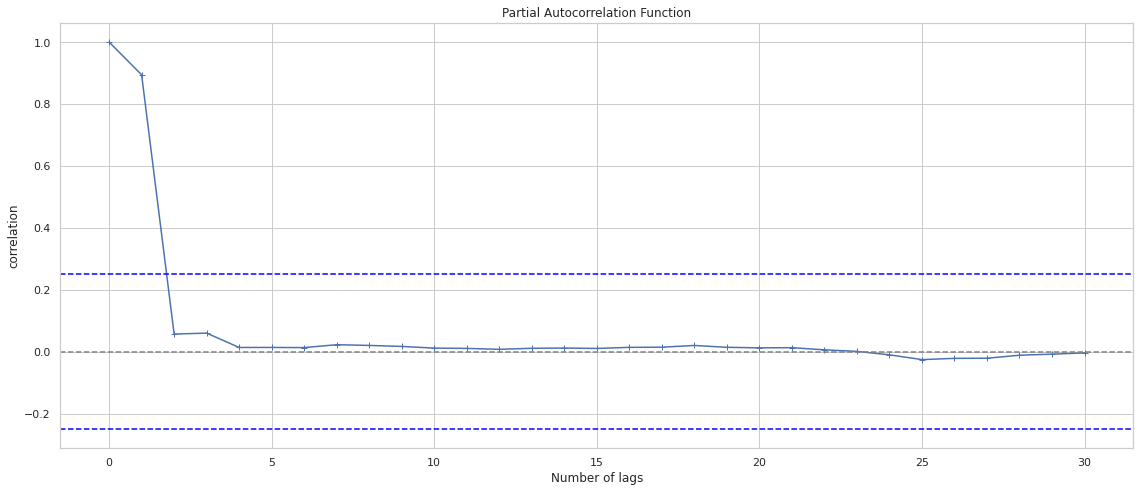

In [8]:
# The variable we choose to apply pacf
y = train['PM10']

#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y= -((np.std(y) * 1.96)) / np.sqrt(len(y)), linestyle='--',color='blue') # lower bound
plt.axhline(y= ((np.std(y) * 1.96)) / np.sqrt(len(y)),linestyle='--',color='blue') # Upper bound
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [9]:
def series_to_supervised(data_df, lag=2):
    
    '''Create lagged features'''
    
    # We create the lag features with the pandas function shift
    lag_df = data_df[[col for col in data_df.columns if col not in ['No', 'year', 'month', 'day', 'hour']]].shift(lag)
    
    # We rename the columùns by adding lag_{lag_value} at the end
    lag_df.columns = [col+"_"+f"lag_{lag}" for col in lag_df.columns]
    
    return lag_df

def rolling_window(data_df, window=1):
    
    # We create the rolling mean features (MA) with the pandas function shift
    rolling_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour', 'PM2.5']]].rolling(window).mean()
    
    # We rename the columùns by adding rolling_{window} at the end
    rolling_df.columns = [col+"_"+f"rolling_{window}" for col in rolling_df.columns]
    
    return rolling_df

In [10]:
# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train, lag=1)
train_lag2 = series_to_supervised(train, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train, window=2)

# Concat everything together
train = pd.concat([train, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train['cum_wspm'] = train['WSPM'].cumsum()

# Saturated vapor pressure
train['saturated_vapor_pressure'] = 6.11*10*((7.5*train['TEMP'])/(237.3+train['TEMP']))
# Actual vapor pressure
train['actual_vapor_pressure'] = 6.11*10*((7.5*train['DEWP'])/(237.3+train['DEWP']))

# Lag features by shift(1) and shift(2)
valid_lag1 = series_to_supervised(valid, lag=1)
valid_lag2 = series_to_supervised(valid, lag=2)

# Rolling window by 2
valid_rolling2 = rolling_window(valid, window=2)

# Concat everything together
valid = pd.concat([valid, valid_lag1, valid_lag2, valid_rolling2], axis=1).dropna()

# Cumulative wind speed
valid['cum_wspm'] = valid['WSPM'].cumsum()

# Saturated vapor pressure
valid['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['TEMP']) / (237.3 + valid['TEMP']))
# Actual vapor pressure
valid['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['DEWP']) / (237.3 + valid['DEWP']))


# Lag features by shift(1) and shift(2)
test_lag1 = series_to_supervised(test, lag=1)
test_lag2 = series_to_supervised(test, lag=2)

# Rolling window by 2
test_rolling2 = rolling_window(test, window=2)

# Concat everything together
test = pd.concat([test, test_lag1, test_lag2, test_rolling2], axis=1).dropna()

# Cumulative wind speed
test['cum_wspm'] = test['WSPM'].cumsum()

# Saturated vapor pressure
test['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['TEMP']) / (237.3 + test['TEMP']))
# Actual vapor pressure
test['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['DEWP']) / (237.3 + test['DEWP']))

# endogenous variables
features_columns = [col for col in train.columns if col not in ['No', 'PM2.5']]

del train_lag1, train_lag2, train_rolling2
del valid_lag1, valid_lag2, valid_rolling2
del test_lag1, test_lag2, test_rolling2

_ = gc.collect()

In [11]:
# Transform the data into DMatrix format for xgboost
d_train = xgb.DMatrix(train[features_columns], train["PM2.5"])
d_val = xgb.DMatrix(valid[features_columns], valid["PM2.5"])
d_test = xgb.DMatrix(test[features_columns].astype("float"))

# Fit and train xgboost
XGB_PARAMS = {'objective': 'reg:gamma',
              'eval_metric': ["rmsle", "mae", "rmse"],
              'boosting_type': 'gbdt',
              'learning_rate': 0.01,
              'colsample_bytree': 0.5,
              'subsample': 0.9,
              'max_depth': 6,
              'min_child_weight': 200,
              'tree_method': 'gpu_hist', 'gpu_id': 0,
              'seed':42
             }

# Train model
model = xgb.train(XGB_PARAMS, d_train, evals=[(d_val, "val")], num_boost_round=15000, verbose_eval=2500,
                          early_stopping_rounds=150)

# Predictions and score on validation data
pred_val = model.predict(d_val)
pred_test = model.predict(d_test)

# Calculate score on validation set
mse_score_valid = mse(y_true=valid["PM2.5"], y_pred=pred_val)
mae_score_valid = mae(y_true=valid["PM2.5"], y_pred=pred_val)
msle_score_valid = msle(y_true=valid["PM2.5"], y_pred=pred_val)
r2_score_valid = r2(y_true=valid["PM2.5"], y_pred=pred_val)

# Calculate score on test set
mse_score_test = mse(y_true=test["PM2.5"], y_pred=pred_test)
mae_score_test = mae(y_true=test["PM2.5"], y_pred=pred_test)
msle_score_test = msle(y_true=test["PM2.5"], y_pred=pred_test)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=pred_test)
print("\n")

print(f"Xgboost rmse valid: {sqrt(mse_score_valid)}")
print(f"Xgboost mae valid: {mae_score_valid}")
print(f"Xgboost rmsle valid: {sqrt(msle_score_valid)}")
print(f"Xgboost r2 valid{r2_score_valid}")

print('\n')

print(f"Xgboost rmse test: {sqrt(mse_score_test)}")
print(f"Xgboost mae test:  {mae_score_test}")
print(f"Xgboost rmsle test: {sqrt(msle_score_test)}")
print(f"Xgboost r2 test: {r2_score_test}")

[20:00:39] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-rmsle:3.58438	val-mae:69.50152	val-rmse:90.57675
[2500]	val-rmsle:0.21220	val-mae:6.02474	val-rmse:10.25401
[5000]	val-rmsle:0.20940	val-mae:5.90167	val-rmse:10.06408
[7500]	val-rmsle:0.20829	val-mae:5.87761	val-rmse:10.00517
[8542]	val-rmsle:0.20792	val-mae:5.87283	val-rmse:9.99032


Xgboost rmse valid: 9.99033105120836
Xgboost mae valid: 5.872826135633793
Xgboost rmsle valid: 0.20791806518696948
Xgboost r2 valid0.9704161698288553


Xgboost rmse test: 9.213810874079305
Xgboost mae test:  5.510857272005299
Xgboost rmsle test: 0.22079387030584086
Xgboost r2 test: 0.9751147384317385


# Configuration

In [12]:
N_SPLITS = 5
SEED = 42

In [13]:
train_data.shape[0] // (N_SPLITS + 1)

60243

In [14]:
np.ceil(train_data.shape[0]*0.1).astype(int)

36147

# XGBOOST CV

In [15]:
# Place holders for predictions
oof_xgb = np.zeros((train_data.shape[0]))
oof_target = np.zeros((train_data.shape[0]))
predictions_xgb = np.zeros((test.shape[0]))
counter = 1


# Placer holders for calculating scores
mse_scores_xgb = []
mae_scores_xgb = []
msle_scores_xgb = []
r2_scores_xgb = []

# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train_data, lag=1)
train_lag2 = series_to_supervised(train_data, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train_data, window=2)

# Concat everything together
train_data = pd.concat([train_data, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train_data['cum_wspm'] = train_data['WSPM'].cumsum()

# Saturated vapor pressure
train_data['saturated_vapor_pressure'] = 6.11*10*((7.5*train_data['TEMP'])/(237.3+train_data['TEMP']))
# Actual vapor pressure
train_data['actual_vapor_pressure'] = 6.11*10*((7.5*train_data['DEWP'])/(237.3+train_data['DEWP']))

# Features to use for training and prediction
features_columns = [col for col in train_data.columns if col not in ['No', 'PM2.5']]

# TimeSeriesSplit validation 
tsp = TimeSeriesSplit(n_splits=5, test_size=np.ceil(train_data.shape[0]*0.1).astype(int))

# Iterate over the whole folds
for trn_idx, vld_idx in tsp.split(train_data):
    
    
    # train valid separation
    print(f"CV {counter}/{N_SPLITS}")
    print('\n')
    
    d_train = xgb.DMatrix(train_data.iloc[trn_idx][features_columns], train_data.iloc[trn_idx]["PM2.5"])
    d_val = xgb.DMatrix(train_data.iloc[vld_idx][features_columns], train_data.iloc[vld_idx]["PM2.5"])
    d_test = xgb.DMatrix(test[features_columns].astype("float"))
    
    # Fit and train xgboost
    XGB_PARAMS = {'objective': 'reg:gamma',
                  'eval_metric': ["rmsle", "mae", "rmse"],
                  'boosting_type': 'gbdt',
                  'learning_rate': 0.01,
                  'max_depth': 6,
                  "min_child_weight": 200,
                  "tree_method": 'gpu_hist', "gpu_id": 0,
                  "seed":SEED
            }
    model = xgb.train(XGB_PARAMS, d_train, evals=[(d_val, "val")], num_boost_round=15000, verbose_eval=2500,
                      early_stopping_rounds=150)

    # Predictions and score on validation data
    pred_val = model.predict(d_val)
    pred_test = model.predict(d_test)
    
    # Calculate the scores on the validation data
    mse_score_valid = mse(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    mae_score_valid = mae(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    msle_score_valid = msle(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    r2_score_valid = r2(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    
    print('\n')
    print(f"Fold {counter} Xgboost rmse: {sqrt(mse_score_valid)}")
    print(f"Fold {counter} Xgboost  mae: {mae_score_valid}")
    print(f"Fold {counter} Xgboost rmsle: {sqrt(msle_score_valid)}")
    print(f"Fold {counter} Xgboost r2: {r2_score_valid}")
    print('\n')
    
    # Register the score on each fold
    mse_scores_xgb.append(sqrt(mse_score_valid))
    mae_scores_xgb.append(mae_score_valid)
    msle_scores_xgb.append(sqrt(msle_score_valid))
    r2_scores_xgb.append(r2_score_valid)
    
    # Calculate prediction on test set
    oof_xgb[vld_idx] = pred_val
    predictions_xgb += pred_test / N_SPLITS
    counter += 1
    

    
# Inference score
mse_score_test = mse(y_true=test["PM2.5"], y_pred=predictions_xgb)
mae_score_test = mae(y_true=test["PM2.5"], y_pred=predictions_xgb)
msle_score_test = msle(y_true=test["PM2.5"], y_pred=predictions_xgb)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=predictions_xgb)

print(f"Xgboost rmse cv: {np.array(mse_scores_xgb).mean()}")
print(f"Xgboost rmae cv: {np.array(mae_scores_xgb).mean()}")
print(f"Xgboost rmsle cv: {np.array(msle_scores_xgb).mean()}")
print(f"Xgboost r2 cv: {np.array(r2_scores_xgb).mean()}")

print('\n')

print(f"Xgboost rmse test: {sqrt(mse_score_test)}")
print(f"Xgboost rmae test: {mae_score_test}")
print(f"Xgboost rmsle test: {sqrt(msle_score_test)}")
print(f"Xgboost r2 test: {r2_score_test}")

CV 1/5


[20:01:41] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-rmsle:3.57547	val-mae:69.54453	val-rmse:91.07934
[2500]	val-rmsle:0.24189	val-mae:6.06090	val-rmse:10.03290
[5000]	val-rmsle:0.23781	val-mae:5.99991	val-rmse:9.91758
[5042]	val-rmsle:0.23777	val-mae:5.99949	val-rmse:9.91693


Fold 1 Xgboost rmse: 9.916929970573468
Fold 1 Xgboost  mae: 5.999496017134391
Fold 1 Xgboost rmsle: 0.23777262848826844
Fold 1 Xgboost r2: 0.9715683232818362


CV 2/5


[20:02:16] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to

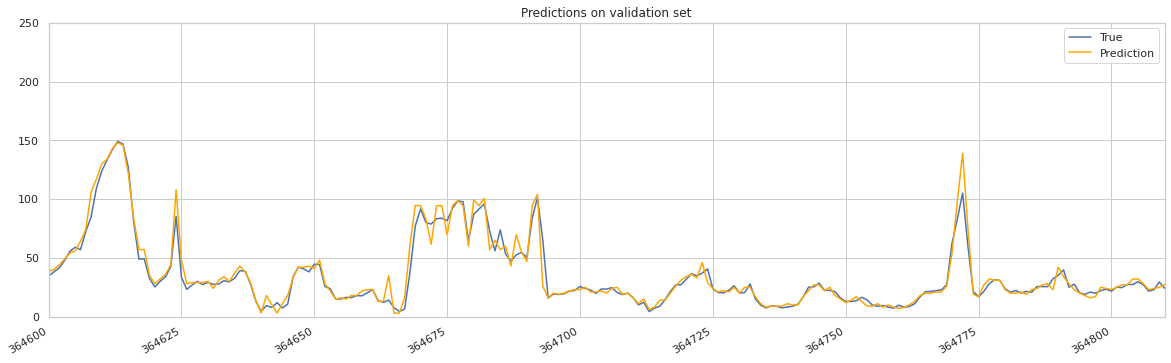

In [16]:
# Create fig size for plotting
fig, ax = plt.subplots(figsize=(20, 6))
# Plot the prediction
ax.plot(test["PM2.5"].index, predictions_xgb, color='b', label='True')
# Plot the true values 
ax.plot(test["PM2.5"].index, test["PM2.5"], color='orange', label='Prediction')

# Set title
ax.set_title("PM2.5", fontweight="bold", size=16)
# Set legend
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([364600, 364810, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on validation set')
plt.show()